In [1]:
#Python 3 ortamı, yüklü birçok faydalı analitik kütüphanesiyle birlikte gelir.
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


Using TensorFlow backend.


In [2]:
#Test verisetini pandas kütüphanesi ile tanımlıyoruz.
df_test = pd.read_csv('../input/test.csv')
#Eğitim verisetini pandas kütüphanesi ile tanımlıyoruz.
df = pd.read_csv('../input/train.csv')

In [3]:
#Sütunları kontrol ediyoruz.
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
#İki veri setindeki toplam yolcu sayısı
df_test.shape[0] + df.shape[0]


1309

In [5]:
#Hayatta kalma oranı
df['Survived'].mean()

0.3838383838383838

In [6]:
#Eğitim setindeki ilk 3 satır
df.head(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [7]:
#eğitim setinde eksik değerleri olan sütunları listele
df.columns[df.isna().any()]


Index(['Age', 'Cabin', 'Embarked'], dtype='object')

In [8]:
#test setinde eksik değerleri olan sütunları listele
df_test.columns[df_test.isna().any()]

Index(['Age', 'Fare', 'Cabin'], dtype='object')

In [9]:
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'
 
def replace_titles(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [10]:
def prepare_data(df):
    
    # Eksik değerleri en çok kullanılan ile doldur.
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    # Eksik yaş değerlerini veri setinin yaş ortalaması ile
    df['Age'].fillna(df['Age'].median(), inplace=True)
    # Eksik ücret değerlerini veri setinin ücret ortalaması ile
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    # Age, SibSp, Parch, Fare verilerini 0 ile 1 arasında ölçeklendir.
    scaler = MinMaxScaler()
    df[['Age','SibSp','Parch','Fare']] = scaler.fit_transform(df[['Age','SibSp','Parch','Fare']])
    
    # Cinsiyetleri 0 ve 1 olarak değiştir.
    df['Sex'] = df['Sex'].map({'female':0,'male':1}).astype(int)
    
    # Class sütununa One hot encoding uygula 
    df_class = pd.get_dummies(df['Pclass'],prefix='Class')
    df[df_class.columns] = df_class
    
    # Biniş limanına One hot encoding uygula.
    df_emb = pd.get_dummies(df['Embarked'],prefix='Emb')
    df[df_emb.columns] = df_emb
    
    # Ad sütunundan başlıkları çıkar ve yeni sütunu doldur.
    df['Title'] = df['Name'].map(lambda x: get_title(x))
    # Replace titles with Mr, Mrs or Miss
    df['Title'] = df.apply(replace_titles, axis=1)
    # Dönüştüren başlıklar için One hot encoding uygula.
    df_title = pd.get_dummies(df['Title'],prefix='Title')
    df[df_title.columns] = df_title
    
    return

In [11]:
#Eğitim veri setini çalıştırın ve sütun adlarını kontrol edin:
prepare_data(df)
 
df.columns

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Class_1', 'Class_2',
       'Class_3', 'Emb_C', 'Emb_Q', 'Emb_S', 'Title', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs'],
      dtype='object')

In [12]:
#Modelde kullanılabilir sütunlar
columns = ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Class_1', 'Class_2',
       'Class_3', 'Emb_C', 'Emb_Q', 'Emb_S', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs']

In [13]:
# Seçilen sütunlar ile oluşturduğum giriş
X = np.array(df[columns])
# Hayatta kalan sütun
y = np.array(df['Survived'])

In [14]:
network = models.Sequential()
network.add(Dense(32, activation='relu', ))
network.add(Dropout(rate=0.2))
network.add(Dense(16, activation='relu'))
network.add(Dropout(rate=0.2))
network.add(Dense(5, activation='relu'))
network.add(Dropout(rate=0.1))
network.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


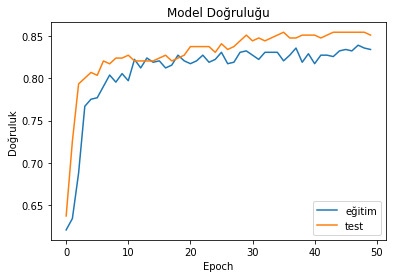

In [15]:
# Modeli derle
network.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
 
# Geçmiş ölçümleri eğit ve kaydet.
history = network.fit(X, y, epochs=50, batch_size=10, verbose=0, validation_split=0.33)
 
# Test doğruluğu ve periyot grafiğini çiz
plt.plot(history.history['acc'], label = 'eğitim')
plt.plot(history.history['val_acc'], label = 'test')
plt.title('Model Doğruluğu')
plt.ylabel('Doğruluk')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [16]:
prepare_data(df_test)
 
X_pred = np.array(df_test[columns])
y_pred = network.predict(X_pred)
 
y_pred = y_pred.reshape(418)
 
# Yolcu kimliğini ve hayatta kalma tahminini birleştir
df_subm = pd.DataFrame({'PassengerId':df_test['PassengerId'],'Survived':y_pred})
 
# İlk 5 satırı listele
df_subm.head()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,PassengerId,Survived
0,892,0.060112
1,893,0.387700
2,894,0.025235
3,895,0.141366
4,896,0.511152


In [17]:
#Binary(0 veya 1) dönüştür.
def binary(x):
#Eğer 0,5'in tahmin üzerinde ise 1 olarak kaydet.Değilse 0 olarak kaydet.
    if x > 0.5:
        return 1
    else:
        return 0
    
# Survived sütunundaki tüm değerlere aynısını uygula.
df_subm['Survived'] = df_subm['Survived'].apply(binary)
df_subm.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [18]:
time_string = time.strftime("%Y%m%d-%H%M%S")
 
# Dosya adını belirle
filename = 'titanic_submission_irem' '.csv'
 
# Csv olarak kaydet
df_subm.to_csv(filename,index=False)
 
print('Saved file: ' + filename)

Saved file: titanic_submission_irem.csv
